## Libraries

In [28]:
import pandas as pd
from linearmodels import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [29]:
file_path = 'resources\Desktoppanel.csv'
data = pd.read_csv(file_path)

## Data Preprocessing

In [30]:
회사법인_구분 = 'aq2002'
상장여부 = 'aq2003'
전문경영인_유무 = 'aq2004'
기업_경영체제 = 'aq2901'


주식회사 = 1
유한회사 = 2
합자회사 = 3
합명회사 = 4


예 = 1
아니오 = 2


소유경영체제 = 1
소유주_중심의_경영체제 = 2
주요_경영문제_결정권을_소유주가_가진_경영체제 = 3
전문경영체제 = 4
해당없음 = 97


미상장 = 4


def determine_management_system(row):
    if row[전문경영인_유무] == 예:
        return 전문경영체제
    elif row[상장여부] < 미상장:
        return 소유주_중심의_경영체제
    elif row[회사법인_구분] == 합자회사:
        return 주요_경영문제_결정권을_소유주가_가진_경영체제
    else:
        return 소유경영체제

fixed_management_data = data[[전문경영인_유무, 상장여부, 회사법인_구분]].apply(determine_management_system, axis=1).fillna(해당없음)

data[기업_경영체제] = data[기업_경영체제].combine_first(fixed_management_data)
data = pd.get_dummies(data, columns=[], drop_first=True)

data[기업_경영체제].value_counts()

aq2901
1.0     12292
4.0      3786
3.0      1770
2.0      1448
97.0     1296
Name: count, dtype: int64

## Estimation Structure

$$
\ln{Y_{iprt}} = \beta (Treat_i \times Post_t) + X_{iprt}\gamma + Fixed + \varepsilon_{ist}
$$

### Controlled Vars

|             통제변수              |              코드              |                                     비고                                      |
|:-----------------------------:|:----------------------------:|:---------------------------------------------------------------------------:|
|            재택근무 비율            |   'epq2007', 'epq9904' or    |                  (전체 - 재택 수) / 전체 [~2013] or 시행 여부 [2015~]                  |
|          최저임금 근로자 비율          |                              |                                                                             |
|            기업 순이익             |                              |                                                                             |
|         추가 근로제도 시행 여부         |                              |                                                                             |
|             경영 형태             |           'aq2901'           |                                                                             |
|            사업체 업력             |           'w_age'            |                                                                             |
|            기업체 변화             | 'aq2012r4~r8, r11, r13, r14' |                                                                             |
|      주력 제품의 국내 시장 경쟁 정도       |           'aq3008'           |                                                                             |
|           사업장 혁신 유형           |           'aq3901'           |                                                                             |
|   능력, 근무성적, 태도 등에 대해 평가 실시함   |           'cq1001'           |                                                                             |
|         성과배분제도 운영 여부          |           'cq3001'           |                                                                             |
|         우리사주제도 실시 여부          |           'cq3008'           |                                                                             |
|    지난 2년 동안 직무분석 실시한 적 있음     |          'dq1007b'           |                                                                             |
| 사무직 근로자의 초과근로가 정기적으로 이루어지는 정도 |           'dq3023'           |                              na at 2005, 2007                               |
|        선택적 근무시간제를 운영함         |           'dq3025'           |                                                                             |
|        탄력적 근로시간제를 운영함         |           'dq3027'           |                                                                             |
|        작년말 기준 노동조합이 있음        |           'mq1001'           |                                                                             |
|       작년 말 기준 노사협의회가 있음       |           'nq1004'           |                            mq1001 + nq1004 가능할듯                             | 

### Fixed vars
 
|    고정효과    |
|:----------:|
|     지역     |
|     연도     |
|    산업분류    |
|     규모     |
| 산업규모 * 연도  |
|   연도별 기업   |
|   연도별 지역   |

aq2901
1.0     12292
4.0      3786
3.0      1770
2.0      1448
97.0     1296
Name: count, dtype: int64

## Regression

In [ ]:
# Compute pairwise correlation of columns
correlation_matrix = X.corr()
# Display the correlation matrix
print(correlation_matrix)

formula = 'y ~ X'

model = smf.ols(formula=formula, data=data).fit().get_robustcov_results()

print(model.summary())

## Visualization

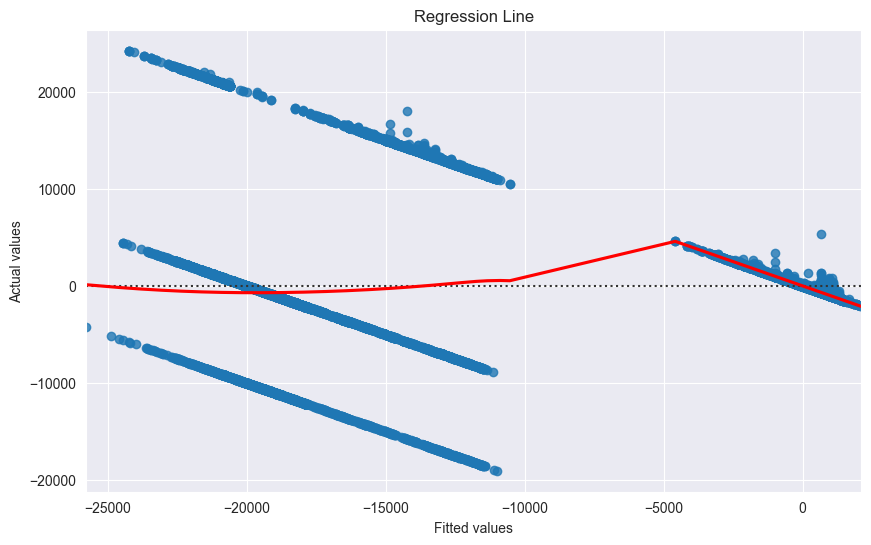

In [5]:
plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=y, lowess=True, line_kws={"color": "red"})
plt.xlabel('Fitted values')
plt.ylabel('Actual values')
plt.title('Regression Line')
plt.show()